<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #3


## Tutorial 2.2 PyCBC Tutorial, Matched Filtering in Action

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how find a specific signal in LIGO data. We present matched filtering in PyCBC, which is optimal in the case of Gaussian noise and a known signal model. In reality our noise is not entirely Guassian, and in practice we use a variety of techniques to separate signals from noise in addition to the use of the matched filter. 

Additional [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html)

## Installation (execute only if running on a cloud platform!)

In [ ]:
# -- Use the following for Google Colab
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3'

     |████████████████████████████████| 28.5MB 146kB/s 
     |████████████████████████████████| 3.1MB 47.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6MB 43.6MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 1.0MB 42.9MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 2.6MB 45.2MB/s 


**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

### Looking for a specific signal in the data

If you know what signal you are looking for in the data, then matched filtering is known to be the optimal method in Gaussian noise to extract the siganl. Even when the parameters of the signal are unkown,  one can test for each set of parameters one is interesting in finding.

#### preconditioning the data 
 
The purpose of this is to reduce the dynamic range of the data and  supress low freqeuncy behavior which can introduce numerical artefacts. We may also wish to reduce the sample rate of the data if high frequency content is not important. PyCBC contains an interface to the GWOSC catalog, so you can easily access the data and parameters of the published gravitational-wave signals

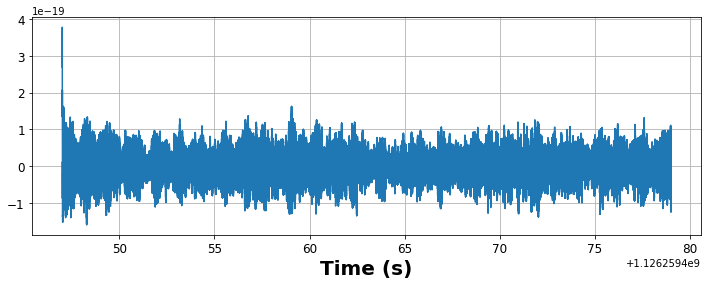

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from scipy.optimize import curve_fit
from scipy import optimize

# As an example we use the GW150914 data
merger = Merger("GW150914")
#merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('L1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

plt.figure(figsize=(12,4))
plt.plot(strain.sample_times, strain)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.xlabel('Time (s)',size=20,weight='bold')
plt.show()

_Note_: To read data from a local file instead of from the GWOSC server, we can use the [pycbc.frame.read_frame(file, channel_name)](https://github.com/gwastro/pycbc/blob/master/docs/frame.rst) method.

#### filter wraparound 

Note the spike in the data at the boundaries. This is caused by the highpass and resampling stages filtering the data. When the filter is applied to the boundaries, it wraps around to the beginning of the data. Since the data itself has a discontinuity (i.e. it is not cyclic) the filter itself will ring off for a time up to the length of the filter. 

Even if a visible transient is not seen, we want to avoid filters that act on times which are not causally connect. To avoid this we trim the ends of the data sufficiently to ensure that they do not wraparound the input. We will enforce this requirement in all steps of our filtering.

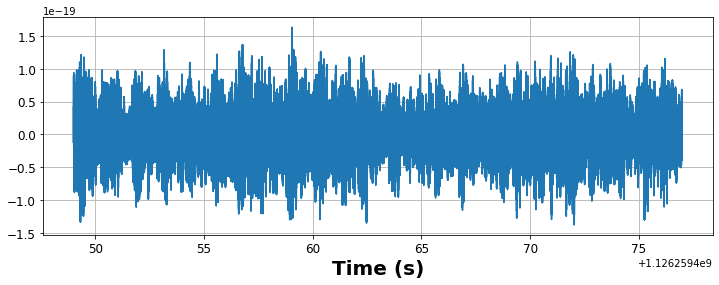

In [9]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

plt.figure(figsize=(12,4))
plt.plot(conditioned.sample_times, conditioned)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.xlabel('Time (s)',size=20,weight='bold')
plt.show()

#### calculate the power spectral density

Optimal matched filtering requires weighting the frequency components of the potential signal and data by the noise amplitude. We can view this as filtering the data with the time series equivelant of 1 / PSD. To ensure that we can control the effective length of the filter, we window the time domain equivalent of the PSD to a specific length. This has the effect of losing some information about line behavior in the detector, however, since our signals span a large frequency range, and lines are narrow, this is a negligible effect.

Important note: Computing a PSD from data that might contain signals, non-Gaussianities and non-stationarities is not trivial. In this example we use Welch's method to obtain a PSD estimate. PyCBC's PSD module contains tools for measuring PSDs, or directly using pre-generated PSDs.

In [10]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=15)

#### make your signal model

Conceptually, matched filtering involves laying the potential signal over your data and integrating (after weighting frequencies correctly). If there is a signal in the data that aligns with your 'template', you will get a large value when integrated over.

Text(0, 0.5, 'Strain')

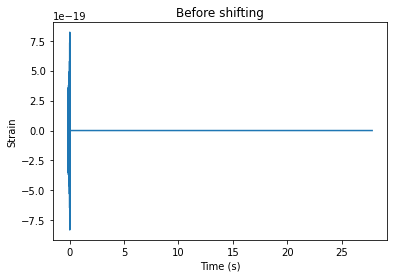

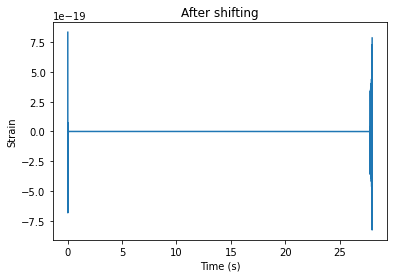

In [11]:
from pycbc.waveform import get_td_waveform
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, and non-rotating black holes which is within the posterior probability
# of GW150914. 
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=30)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# The cyclic_time_shift method shifts the timeseries by a given amount of time.
# It treats the data as if it were on a ring so points shifted off the end
# of the series reappear at the start. Note that time stamps are *not* in
# general affected (as the start time of the full array is shifted),
# but the index of each point in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
plt.figure()
plt.title('Before shifting')
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

plt.figure()
plt.title('After shifting')
plt.plot(template.sample_times, template)
plt.xlabel('Time (s)')
plt.ylabel('Strain')

#### calculating the signal-to-noise time series

In this section we will now calculate the signal-to-noise time series for our template. We'll take care to handle issues of filter corruption / wraparound by truncating the output time series. We need to account for both the length of the template and 1 / PSD.

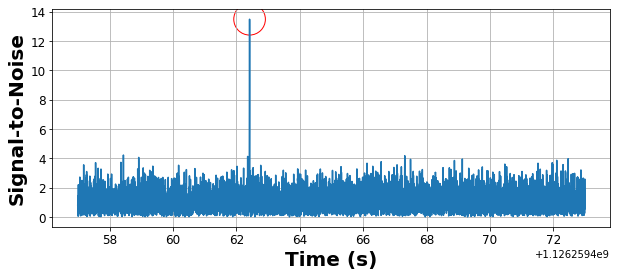

We found a signal at 1126259462.4174805s with SNR 13.478036832202513


In [18]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=30)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-Noise',size=20,weight='bold')
plt.xlabel('Time (s)',size=20,weight='bold')
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()


peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

plt.scatter([time],[abs(snrp)],s=1000, facecolors='none', edgecolors='r')

plt.show()

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

### Aligning and Subtracting the Proposed Signal

In the previous section we found a peak in the signal-to-noise for a proposed binary black hole merger. We can use this SNR peak to align our proposal to the data, and to also subtract our proposal from the data.

In [20]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

#### Visualize the overlap between the signal and data

To compare the data an signal on equal footing, and to concentrate on the frequency range that is important. We will whiten both the template and the data, and then bandpass both the data and template between 30-300 Hz. In this way, any signal that is in the data is transformed in the same way that the template is.

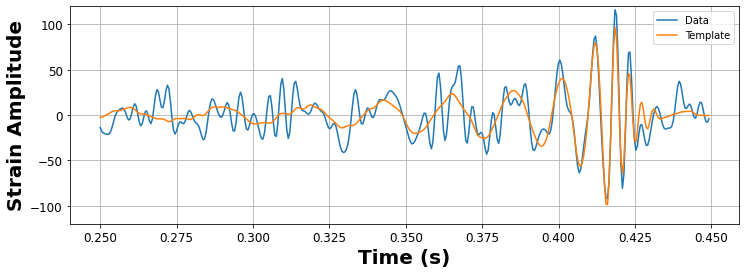

In [22]:
# We do it this way so that we can whiten both the template and the data
shift = 1.126259462e+9 #shift by this amount in plotting to get time in seconds
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(20., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(20, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.15, merger.time+.05)
white_template = white_template.time_slice(merger.time-.15, merger.time+.05)


plt.figure(figsize=[12, 4])
plt.plot(white_data.sample_times-shift, white_data, label="Data")
plt.plot(white_template.sample_times-shift, white_template, label="Template")
plt.legend()
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.ylabel('Strain Amplitude',size=20,weight='bold')
plt.xlabel('Time (s)',size=20,weight='bold')
plt.ylim(-120,120)
plt.show()

# plt.figure(figsize=[12, 5])
# plt.plot(white_data.sample_times, white_data - white_template, label="Data")
# plt.legend()
# plt.show()

## Fit the first inspiral near merger time
### Fit function $f(t) = A e^{-\gamma t} \cos(\frac{\omega t}{t - t_{m}} + \delta)$

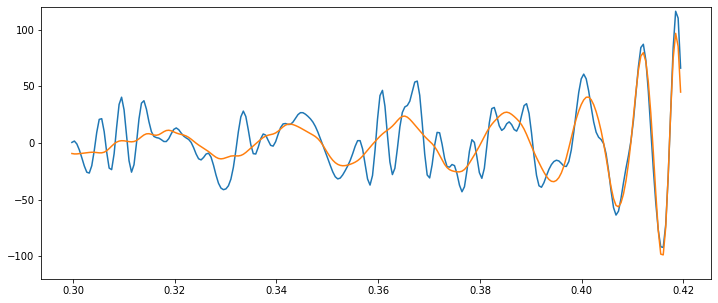

In [23]:
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(20., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(20, 512).lowpass_fir(300, 512)

#define the time of inspiral event
white_data = white_data.time_slice(merger.time-.1, merger.time+0.02)
white_template = white_template.time_slice(merger.time-.1, merger.time+0.02)

def OsccilatingFunction(x, A, E, w, s, g):
    return A*np.cos(w*x/(x-E) + s)*np.exp(-(g*x))

plt.figure(figsize=[12, 5])
plt.plot(white_data.sample_times-shift, white_data, label="Data")
plt.plot(white_template.sample_times-shift, white_template, label="Template")
plt.ylim(-120,120)
plt.show()



## Begins Fitting to Data

                     A          E          w          s          g
          A   1.05e-12  -1.25e-11  -1.49e-09  -3.13e-09   4.72e-06
          E  -1.25e-11   9.26e-06   1.39e-03   3.96e-03  -5.93e-05
          w  -1.49e-09   1.39e-03   2.12e-01   6.10e-01  -7.13e-03
          s  -3.13e-09   3.96e-03   6.10e-01   1.80e+00  -1.51e-02
          g   4.72e-06  -5.93e-05  -7.13e-03  -1.51e-02   2.12e+01
Fit results:
Parameters:
A      0.00000 ±  0.00000
E      0.46913 ±  0.00304
w      5.13216 ±  0.46012
s     -38.78797 ±  1.34012
g     -45.57348 ±  4.60192


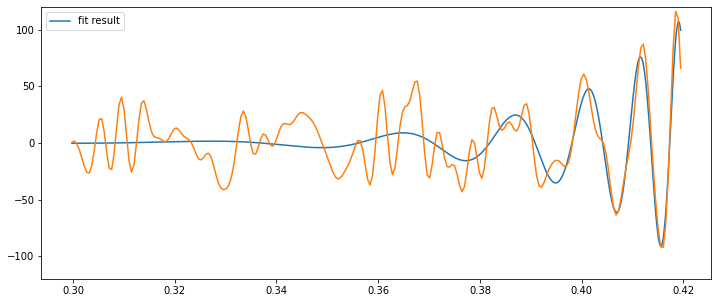

In [24]:
datax = np.asarray(white_data.sample_times-shift)
datay = np.asarray(white_data)
plotx = np.linspace(min(datax),max(datax),1000)

start_vals = np.array([10000.0021, .4960, 15.33006,1.90315,-35.1]) #initial guess
param_dict=['A','E','w','s','g']


popt,pcov = optimize.curve_fit(OsccilatingFunction,xdata=datax,ydata=datay,p0=start_vals,maxfev=10000000)

print("="*20)
print("{:>11s}".format(""),end="")
for i in range(len(popt)):
    print("{:>11s}".format(param_dict[i]),end="")
print("")
for i in range(len(popt)):
    print("{:>11s}".format(param_dict[i]),end="")
    for j in range(len(popt)):
        print("{:11.2e}".format(pcov[i,j]),end="")
    print("")

print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))


fig, ax = plt.subplots(1,1,figsize=(12,5)) 
ax.plot(plotx,OsccilatingFunction(plotx,*popt[0:6]), label = "fit result")
plt.plot(datax,datay)
plt.ylim(-120,120)
ax.legend()
plt.show()

After 0.38s the fit is off we try again from 0.30 to 0.38s

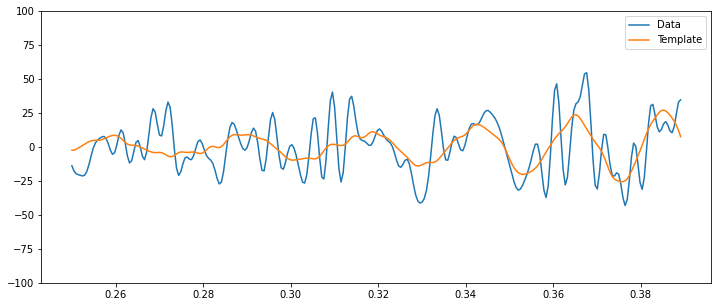

                     A          E          w          s          g
          A   1.79e-02  -6.83e-05  -8.06e-03  -1.65e-03  -3.94e-01
          E  -6.83e-05   4.48e-04   7.14e-02   3.95e-02   1.89e-03
          w  -8.06e-03   7.14e-02   1.15e+01   6.43e+00   2.35e-01
          s  -1.65e-03   3.95e-02   6.43e+00   3.70e+00   6.56e-02
          g  -3.94e-01   1.89e-03   2.35e-01   6.56e-02   8.73e+00
Fit results:
Parameters:
A      0.00000 ±  0.13396
E      0.46913 ±  0.02116
w      5.13216 ±  3.38890
s     -38.78797 ±  1.92465
g     -45.57348 ±  2.95411


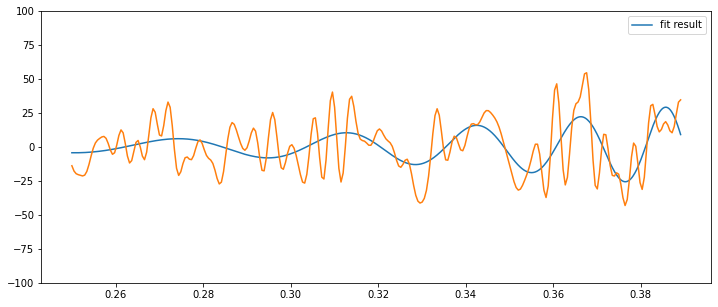

In [25]:
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(20., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(20, 512).lowpass_fir(300, 512)

white_data = white_data.time_slice(merger.time-.15, merger.time-0.01)
white_template = white_template.time_slice(merger.time-.15, merger.time-0.01)


plt.figure(figsize=[12, 5])
plt.plot(white_data.sample_times-shift, white_data, label="Data")
plt.plot(white_template.sample_times-shift, white_template, label="Template")
plt.legend()
plt.ylim(-100,100)
plt.show()


datax = np.asarray(white_data.sample_times)-shift
datay = np.asarray(white_data)

start_vals = np.array([1.41298, 0.55, 10.30128,13.49541,-10.90879])
param_dict=['A','E','w','s','g']

popt0,pcov = optimize.curve_fit(OsccilatingFunction,xdata=datax,ydata=datay,p0=start_vals,maxfev=10000000)

print("="*20)
print("{:>11s}".format(""),end="")
for i in range(len(popt0)):
    print("{:>11s}".format(param_dict[i]),end="")
print("")
for i in range(len(popt0)):
    print("{:>11s}".format(param_dict[i]),end="")
    for j in range(len(popt0)):
        print("{:11.2e}".format(pcov[i,j]),end="")
    print("")

print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))

plotx = np.linspace(min(datax),max(datax),1000)
fig, ax = plt.subplots(1,1,figsize=(12,5)) 
ax.plot(plotx,OsccilatingFunction(plotx,*popt0[0:5]), label = "fit result")
plt.plot(datax,datay)
plt.ylim(-100,100)
ax.legend()
plt.show()

Now fit the ring-down

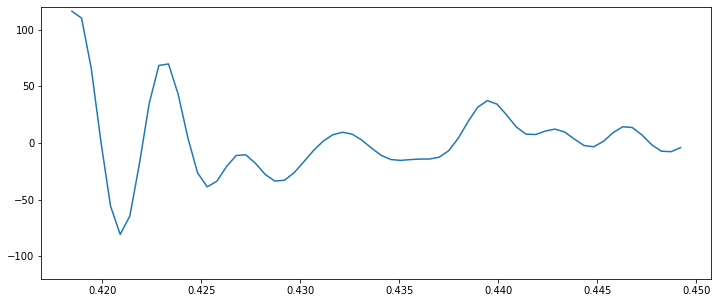

                     A          w          s          g
          A   2.93e+80  -4.47e+40   1.89e+40   4.76e+41
          w  -4.47e+40   1.00e+03  -4.21e+02  -7.22e+01
          s   1.89e+40  -4.21e+02   1.77e+02   3.05e+01
          g   4.76e+41  -7.22e+01   3.05e+01   7.73e+02
Fit results:
Parameters:
A      0.00000 ± 17126671797350374210204037660714253418496.00000
w      0.46913 ± 31.62590
s      5.13216 ± 13.31729
g     -38.78797 ± 27.80824


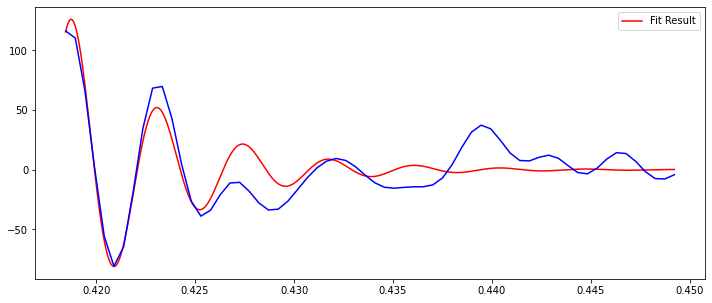

In [26]:
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(20., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(20, 512).lowpass_fir(300, 512)

white_data = white_data.time_slice(merger.time+.0185, merger.time+0.05)
white_template = white_template.time_slice(merger.time+.0185, merger.time+0.05)

datax = np.asarray(white_data.sample_times)-shift
datay = np.asarray(white_data)


def DampingFunction(x, A, w, s, g):
    return A*np.cos(w*x + s)*np.exp(-g*x)


x2 = np.linspace(min(datax),max(datax),1000)
y2 = DampingFunction(x2,100,500.,1,20)

plt.figure(figsize = (12,5))
#plt.plot(x2,y2,'r')
plt.plot(datax,datay)
plt.ylim(-120,120)
plt.show()


param_dict=['A','w','s','g']

start_vals = np.array([-100000.843, -800.48760, 1.77006,5.80315])

plotx = np.linspace(min(datax),max(datax),1000)#np.linspace(min(datax),max(datax),1000)/1126259462*10e+8 - 1000000000

popt2,pcov = optimize.curve_fit(DampingFunction,xdata=datax,ydata=datay,p0=start_vals,maxfev=100000)
print("="*20)
print("{:>11s}".format(""),end="")
for i in range(len(popt2)):
    print("{:>11s}".format(param_dict[i]),end="")
print("")
for i in range(len(popt2)):
    print("{:>11s}".format(param_dict[i]),end="")
    for j in range(len(popt2)):
        print("{:11.2e}".format(pcov[i,j]),end="")
    print("")

print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))


fig, ax = plt.subplots(1,1,figsize=(12,5)) 
ax.plot(plotx,DampingFunction(plotx, *popt2),color = 'r',label="Fit Result")
plt.plot(datax,datay,'b')
ax.legend()
plt.show()

Put the fit parameters back to the funtion, be careful with A = 0.00000000 and very large A

In [27]:
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(20., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(20, 512).lowpass_fir(300, 512)

#plot the whole range 
white_data = white_data.time_slice(merger.time-.15, merger.time+.05)
white_template = white_template.time_slice(merger.time-.15, merger.time+.05)

datax = np.asarray(white_data.sample_times) - shift

xdata = np.linspace(min(datax),max(datax),len(datax)) 
ydata = np.zeros(len(datax))

x = np.linspace(min(datax),max(datax),409)
y = OsccilatingFunction(x, *popt)#0.0000006, 0.46913, 5.13236,-38.78739,-45.57235)

x0 = np.linspace(min(datax),max(datax),409)
y0 =  OsccilatingFunction(x0, *popt0)#-0.12660, 0.57739, 22.63191,36.09615,-14.10774)

x2 = np.linspace(min(datax),max(datax),409)
#y2 = DampingFunction(x2 , 1206371114449438935927853274838633283584.00000, -1449.78698, 274.20640, 203.80018)
y2 = DampingFunction(x2, *popt2)

Stitch each part of the fit together and make them look nicer. Very tedious 

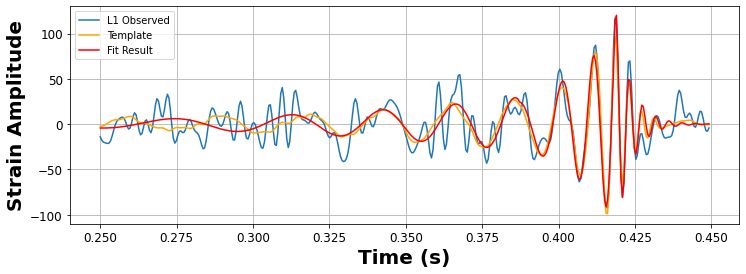

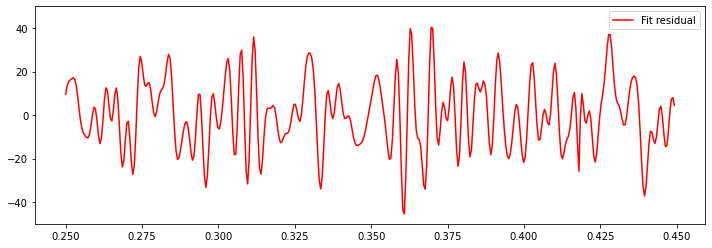

In [30]:
for i in range(len(x0)):
    if x0[i] >  0.387:
        y0[i] = 0
    else:
        y0[i] = y0[i]
        
for i in range(len(x)):
    if x[i] >  0.41796875:
        y[i] = 0
    if x[i] < 0.387:
        y[i] = 0

for i in range(len(x2)):
    if x2[i] < 0.41799999:
        y2[i] = 0

combined_fit = y0 + y +y2 


plt.figure(figsize = (12,4)) 
plt.plot(white_data.sample_times-shift, white_data, label="L1 Observed")
plt.plot(white_template.sample_times-1.126259462e+9, white_template, color = 'orange',label="Template")
plt.plot(x0,combined_fit,color = 'red' ,label="Fit Result")
plt.legend(loc = 2)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.ylabel('Strain Amplitude',size=20,weight='bold')
plt.xlabel('Time (s)',size=20,weight='bold')
plt.ylim(-110,130)
plt.show()

#plot residual
plt.figure(figsize = (12,4))
#plt.plot(white_data.sample_times-shift,white_template - white_data, color = 'b',label = "Template residual")
plt.plot(white_data.sample_times-shift,combined_fit - white_data, color = 'r',label = "Fit residual")
plt.ylim(-50,50)
plt.legend()
plt.show()

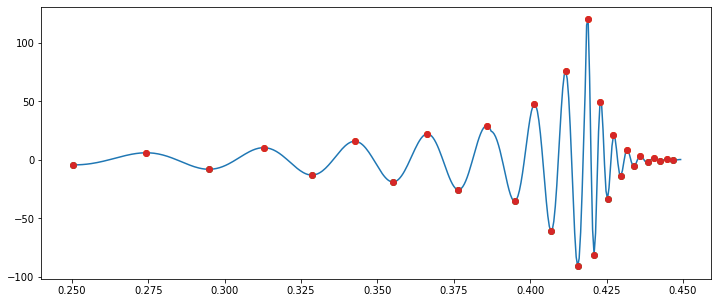

In [32]:
peaks = np.where((combined_fit[1:-1] > combined_fit[0:-2]) * (combined_fit[1:-1] > combined_fit[2:]))[0] + 1
dips = np.where((combined_fit[1:-1] < combined_fit[0:-2]) * (combined_fit[1:-1] < combined_fit[2:]))[0] + 1

local_max_min = np.sort(np.concatenate([peaks,dips]))
                 
# The above makes a list of all indices where the value of y[i] is greater than both of its neighbours
# It does not check the endpoints, which only have one neighbour each
# The extra +1 at the end is necessary because where finds the indices within the slice y[1:-1],
# not the full array y. The [0] is necessary because where returns a tuple of arrays, where the first element 
# is the array we want.

plt.figure(figsize = (12,5))
plt.plot (x, combined_fit)
plt.plot (x[peaks], combined_fit[peaks], 'o')
plt.plot (x[dips], combined_fit[dips], 'o')
plt.plot (x[local_max_min], combined_fit[local_max_min],'o')
plt.show()

In [33]:
#find average change in freq and df
f = np.zeros(7)
df = np.zeros(6)
for i in range(7): #frequency up to the merger event
    t = x[peaks][i+1] - x[peaks][i]
    f[i] = 1.0/t
    
ave_f = sum(f)/7

for i in range(len(f)-1): #change in frequency up to merger event
    df[i] = (f[i+1]-f[i])/(x[peaks][i+2] -  x[peaks][i])
    
ave_df = sum(df)/6


f_t = np.zeros(len(x[local_max_min])) #all frequency in the range [0.25,0.45]
for i in range(len(x[local_max_min])-1):
    t = x[local_max_min][i+1] - x[local_max_min][i]
    f_t[i] = 0.5/t

In [36]:
def chirpMass(f,fdot,c,G):
    return ((c**3/G*(5/96*np.pi**(-8/3)*fdot/(f**(11/3)))**(3/5))/(1.99e+30))

c = 3.00e+8
G = 6.674e-11
M = 72.19*1.99e+30
print(M)
print(ave_f,ave_df)
chirpMass(ave_f,ave_df,c,G)

1.436581e+32
64.4888043783606 726.6754520067894


30.105284112304783

# Uncertainty calculations

$M = k (f^{-11/3}\dot f)^{3/5} $ Where $k$ is constant $c^{3}/G($stuff$)^{3/5}$

$\delta M = \sqrt(\frac{\partial M}{\partial f} \delta f)^{2} + (\frac{\partial M}{\partial \dot f} \delta \dot f)^{2}$

Apply the same rule to $\delta f$ and $\delta \dot f$, which only depends on $\delta t$

$\delta f = \frac{\text{number of wavelengths}}{t^2} \delta t$

$\delta \dot f = \frac{\text{2 number of wavelengths}}{t^3} \delta t$

In [ ]:
uncertainty_time = x0[2]-x0[0] #1st order time uncertainty to the nearest 3rd neighbor
erf = 7.0*uncertainty_time/(x[peaks][7] - x[peaks][0])
erdf = 7.0*2.0*uncertainty_time/(x[peaks][7] - x[peaks][0])

k = c**3/G*(5/96*np.pi**(-8/3))**(3/5)
erChirpMass = np.sqrt((k*11/5*ave_f**(-16/5)*ave_df**(3/5)*erf)**2 + (k*3/5*ave_f**(-11/5)*ave_df**(-2/5)*erdf)**2)/(1.99e+30)
print("Uncertainty of Chirp Mass is",erChirpMass)

Uncertainty of Chirp Mass is 0.048632391803633546


$\mathcal{M} = 30.10 \pm  0.05$ Solar Mass

# Black hole relative velocity

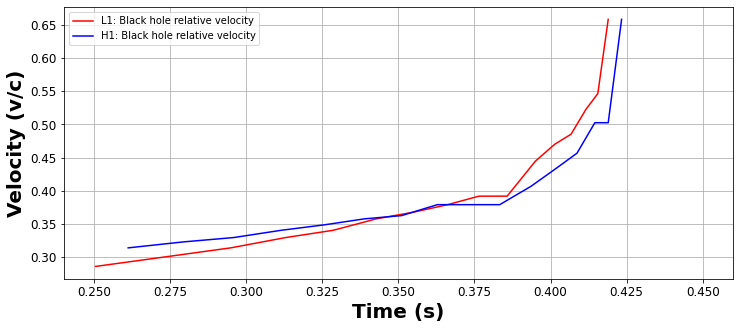

In [37]:
#vH and time_H1 are calculated in H1 file and copied over here
vH = np.asarray([0.31371375, 0.32268181, 0.32926897, 0.34025261, 0.3484546 ,
       0.35750939, 0.36240739, 0.3789027 , 0.3789027 , 0.3789027 ,
       0.40655361, 0.43373531, 0.4566047 , 0.5025585 , 0.5025585 ,
       0.65853794])
time_H1 = np.asarray([0.26123047, 0.27929688, 0.29589844, 0.31152344, 0.32568359,
       0.33886719, 0.35107422, 0.36279297, 0.37304688, 0.38330078,
       0.39355469, 0.40185547, 0.40869141, 0.41455078, 0.41894531,
       0.42333984])

vL = (G*M*np.pi*f_t)**(1/3)/c #equation for relative velocity
plt.figure(figsize = (12,5))
plt.plot(x[local_max_min][0:-13],vL[0:-13],color = 'red', label = 'L1: Black hole relative velocity') 
'''relative velocity only exists up until the merge event so only plot the before the ring-down'''
plt.plot(time_H1,vH,color = 'blue', label = 'H1: Black hole relative velocity')
plt.xlim(0.240,0.46)
plt.xlabel('Time (s)',size=20,weight='bold')
plt.ylabel('Velocity (v/c)',size=20,weight='bold')
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.legend()
plt.show()

# Ignore stuff below this. Not including these in the report

#### Subtracting the signal from the data

Now that we've aligned the template we can simply subtract it. Let's see below how that looks in the time-frequency plots!

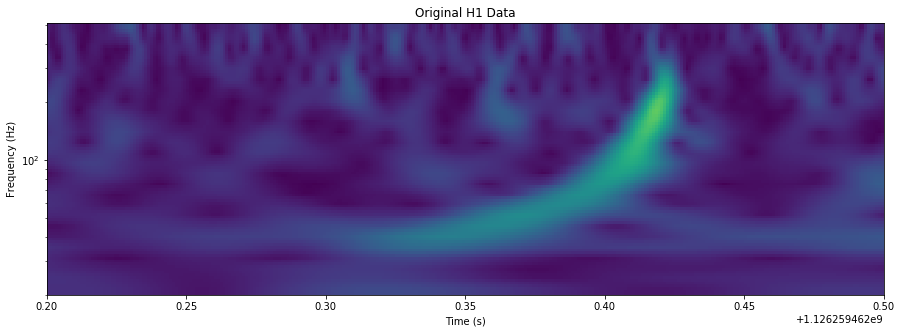

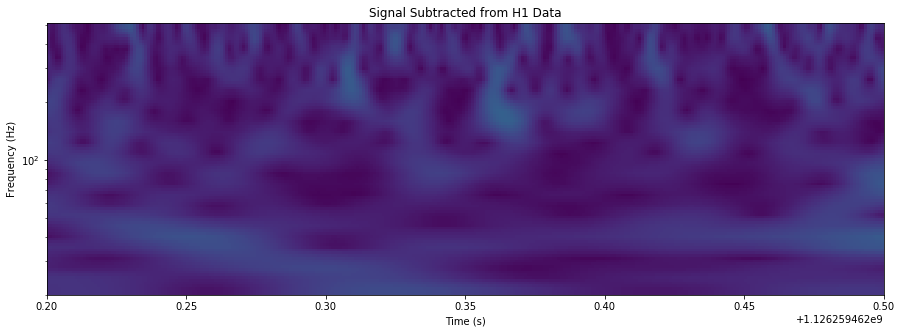

In [ ]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    plt.figure(figsize=[15, 5])
    plt.title(title)
    plt.pcolormesh(t, f, p**0.5, vmin=0, vmax=10)
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(merger.time - .2, merger.time + .1)
    plt.show()

## Challenge!

Use the methods demonstrated above to see if you can calculate the SNR
time series in the following data sets. What is the SNR of each signal?
Which template matched best to which data?

Information that may be useful:

* Signals are all placed between 100 and 120 seconds into the frame file.
* You may assume mass1 = mass1 (equal mass) and that each component mass is one of 15, 30, or 45.
* Each file starts at gps time 0, and ends at gps time 128
* The channel name in each file is "H1:TEST-STRAIN"

In [ ]:
# Download the challenge set files
from pycbc.frame import read_frame
import urllib

def get_file(fname):
    url = "https://github.com/gw-odw/odw-2020/raw/master/Data/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_1.gwf', 'PyCBC_T2_2.gwf']

for fname in files:
    get_file(fname)
    

# An example of how to read the data from these files:
file_name = "PyCBC_T2_0.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:TEST-STRAIN"

start = 0
end = start + 128

ts = read_frame(file_name, channel_name, start, end)

Getting : https://github.com/gw-odw/odw-2020/raw/master/Data/PyCBC_T2_0.gwf
Getting : https://github.com/gw-odw/odw-2020/raw/master/Data/PyCBC_T2_1.gwf
Getting : https://github.com/gw-odw/odw-2020/raw/master/Data/PyCBC_T2_2.gwf
